## <center>An inverse model for inferring surface fluxes and mixing from gridded hydrographic TS data, <br> by Taimoor Sohail and Jan D. Zika


##### <center>We use an optimal transport method, minimzing a cost function which respects the volume and mass conservation, and the fundamental physics of mixing in T-S space. <br>See also: Jan D Zika et al. (2021) [www.doi.org/10.1175/JCLI-D-20-0355.1 ] for a simpler version of this model which optimizes ocean circulation only.
------------

### __The code is laid out as follows:__
#### A) Pre-processing
i) Load necessary modules for computation \
ii) Define key parameters
#### B) Load Data
#### C) Define constraints
i) Define Connectivity \
ii) Define weights
#### D) Run optimisation
#### E) Save Output
---------

## A) Pre-processing

### i) Load necessary modules for computation

In [2]:
## Module to run the minimisation
from WM_Methods import MTM
## The linear optimisation module
import cvxpy as cp 
## Module to track runtime of cells and loops
import time
from tqdm.notebook import tqdm
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
## Module to load files and handle array computations
import xarray as xr
import numpy as np
## Modules to plot outputs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec


### ii) Define key parameters

In [68]:
# Flag to set Q_prior (False = 0; True = actual fluxes)
SF = True
# Setting the value of the biases (only works if SF = True)
HF_offset = 0#-5 #W/m2
FW_offset = 0#0.5 #mm/day
tenpc_offset = False
# Specifying the number of BSP bins, 2^n
tree_depth = 4

In [149]:
volnorming = 1e15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients

# Establish basic constants 
yr2sec = 365.25*24*60*60
# delta(time) in the ACCESS-CM2 model
dt_OG = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/dtime*.nc')
dt_OG['time'] = np.arange(dt_OG.average_DT.size).astype(float)
dt = dt_OG.rename({'time':'Time'})
# Reference density, specific heat capacity and reference salinity
rho = 1035 #kg/m^3
Cp = 3992.10322329649
S0=35

# Range of years over which 'early' and 'late' are defined
dyrs = 9
# Start and end year
init_early = 1988*12
init_late = 1997*12
Early_period = (np.array([init_early,init_early+dyrs*12-1]) - 1850*12)
Late_period = (np.array([init_late,init_late+dyrs*12-1]) - 1850*12)
range_yrs = (init_late-init_early)/12

In [187]:
int_scaling = ((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
int_scaling

0.5

In [182]:
Late_period[-1]-Early_period[0]

215

In [150]:
print(Early_period,\
Late_period,\
range_yrs)

[1656 1763] [1764 1871] 9.0


-----------
## B) Load Data



The data is presented as monthly T-S observations from EN4, from January 1970 to December 2014. The observations have already been binned via Binary Space Partitioning according to a specific criterion. Folowing Sohail et al. (TBD) the BSP partitioning occurs in an xyxyxyx order, shown to minimize variability in the temperature and salinity signals. 



In [151]:
%%time
# Load ACCESS-CM2 data (this data has already been coarsened into basins and BSP bins)
ACCESS_BSP_data = xr.open_mfdataset('../BSP_processed/ACCESS_CM2/BSP_ACCESS_TS_hist_4_bins_*.nc')

## Early Period
Part_early = ACCESS_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SA_early =  ACCESS_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CT_early = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
V_early = ACCESS_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
A_early = ACCESS_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
CTV_early = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])
SAV_early = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Early_period[0],Early_period[1])).sum('Time')/(Early_period[1]-Early_period[0])

## Late Period
Part_late = ACCESS_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SA_late =  ACCESS_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CT_late = (ACCESS_BSP_data.T_mean-273.15).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])-273.15
V_late = ACCESS_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
A_late = ACCESS_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
CTV_late = ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])
SAV_late = (ACCESS_BSP_data.S_mean*ACCESS_BSP_data.V_sum).isel(Time=slice(Late_period[0],Late_period[1])).sum('Time')/(Late_period[1]-Late_period[0])

Basins = ACCESS_BSP_data.Basin.values

CPU times: user 566 ms, sys: 23.6 ms, total: 589 ms
Wall time: 815 ms


In [152]:
## Load the volumetric distribution (in T-S space) of the ACCESS-CM2 model [for figure 3]
ACCESS_TS_dist_hist = xr.open_mfdataset('~/UNSW_work/MIN_MIX_FINAL/TS_Sfunction/TS_distribution_ACCESS_CM2_hist.nc')
# Define T; S bin limits
tbins = ACCESS_TS_dist_hist.tbins.values
sbins = ACCESS_TS_dist_hist.sbins.values
dtbins = np.diff(tbins)[0]
dsbins = np.diff(sbins)[0]

In [153]:
# ## Plot the time-mean volume and volume anomaly in ACCESS-CM2 [Figure 3]

# fig, axs = plt.subplots(1,2, figsize=(7.5*1*1.3,2.5*1.2*1.3), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .2, wspace=0.2)
# axs = axs.ravel()

# (np.log10(ACCESS_TS_dist_hist.TS_distribution/(dsbins*dtbins)).mean('time')).plot(ax=axs[0], cmap=plt.cm.viridis, cbar_kwargs={'label': r"$log_{10}(\overline{V})$ [m$^3$/(Kg/kg)]"})
# (((((ACCESS_TS_dist_hist.TS_distribution.sel(time=slice('2006-01-01', '2014-12-31'))/(dsbins*dtbins)).mean('time')) - \
#          (ACCESS_TS_dist_hist.TS_distribution.sel(time=slice('1979-01-01', '1987-12-31'))/(dsbins*dtbins)).mean('time')))/1e15).plot(ax=axs[1],cmap=plt.cm.bwr, cbar_kwargs={'label': r"$V_1-V_0$ [$\times10^{15}$m$^3$/(Kg/kg)]"}, vmin=-5, vmax=5)

# for i in range(2):
#     # axs[i].set_xlim(30,40)
#     # axs[i].set_ylim(-3,35)
#     axs[0].set_ylabel('Conservative Temperature [$^{\circ}$C]')
#     axs[1].set_ylabel('')
#     axs[i].set_xlabel('Practical Salinity [g/kg]')
# axs[0].set_title('Time-mean volume distribution')
# axs[1].set_title('Volume distribution change')
# plt.savefig('../Figures/ACCESS_CM2_hist_TS_dist_summary.png', dpi=300, bbox_inches='tight')
# plt.show()



##### Calculate the T and S standard deviations, $\sigma_T; \sigma_S$, for weights $w_j$

In [154]:
## Remove NaNs to calculate standard deviation
T_nonan = ACCESS_TS_dist_hist.tbins.expand_dims(dim={"sbins": ACCESS_TS_dist_hist.sbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"sbins": ACCESS_TS_dist_hist.sbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
S_nonan = ACCESS_TS_dist_hist.sbins.expand_dims(dim={"tbins": ACCESS_TS_dist_hist.tbins.size, "time":ACCESS_TS_dist_hist.time.size}).\
assign_coords({"tbins": ACCESS_TS_dist_hist.tbins, "time":ACCESS_TS_dist_hist.time})*(ACCESS_TS_dist_hist.TS_distribution/ACCESS_TS_dist_hist.TS_distribution)
# Calculate standard deviation
T_nonan_std = T_nonan.std(skipna=True).values
S_nonan_std = S_nonan.std(skipna=True).values
# Weights are 1/std
T_scale = 1/T_nonan_std
S_scale = 1/S_nonan_std

##### Plot BSP bins and $V_0$, $T_0$ and $S_0$ [Figure 4]

In [155]:
%%time
# Load the early partition values and volumes
Part_early.load()
V_early_vals = np.log10(V_early.values)
V_early_vals[~np.isfinite(V_early_vals)] = 0

# Load the geographical masks, \omega
mask_EN4_xr = xr.open_mfdataset('../Basin_mask/mask_EN4.nc')
mask_EN4 = (mask_EN4_xr.__xarray_dataarray_variable__.isel(depth=0).values)
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_0*')
lats = data.lat.values
lons = data.lon.values

mask_EN4[mask_EN4==0] = np.nan


CPU times: user 1.7 s, sys: 187 ms, total: 1.89 s
Wall time: 2.22 s


In [156]:
# ## Plot the BSP bins, mean T and S, early volume, and the corresponding masks \omega
# fig, axs = plt.subplots(3,3, figsize=(7.5*1.2,7.5*1.2), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .35, wspace=0.25)
# axs = axs.ravel()

# minv, maxv = 12,17

# cmap = plt.cm.viridis
# norm = plt.Normalize(minv, maxv)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# axis_locs = [[0.1275, 0.825, 0.1, 0.05],
# [0.4075, 0.825, 0.1, 0.05],
# [0.797, 0.825, 0.1, 0.05],
# [0.1275, 0.5475, 0.1, 0.05],
# [0.4075, 0.5475, 0.1, 0.05],
# [0.688, 0.5475, 0.1, 0.05],
# [0.1275, 0.27, 0.1, 0.05],
# [0.4075, 0.27, 0.1, 0.05],
# [0.688, 0.27, 0.1, 0.05]]

# for i in range(Basins.size):
#     axins = fig.add_axes(axis_locs[i], projection = ccrs.Robinson())
#     axins.pcolormesh(lons, lats, mask_EN4[i,:,:], transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap=plt.cm.Reds)
#     axins.add_feature(cfeature.LAND.with_scale('50m'), zorder=100, color='grey', edgecolor=None)
#     axins.coastlines()
#     axins.set_xticklabels([])
#     axins.set_yticklabels([])
#     axins.set_xticks([])
#     axins.set_yticks([])
#     axins.set_extent([-180,180, -83,90], crs=ccrs.PlateCarree())

# for j in range(Basins.size):
#     for i in range(2**tree_depth):
#         axs[j].add_patch(patches.Rectangle((Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,2]-273.15), \
#             Part_early.isel(Basin=j)[i,1]-Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,3]-Part_early.isel(Basin=j)[i,2], ec='black', facecolor=cmap(norm((V_early_vals[j,i]))), zorder=-1000))
#     axs[j].scatter(SA_early.isel(Basin=j).values.flatten(),CT_early.isel(Basin=j).values.flatten(),20, marker='o', color='white', ec='black')
#     axs[j].set_xlim(30,40)
#     axs[j].set_title(Basins[j])
#     axs[j].set_ylabel('Temperature [$^{\circ}$C]')
#     axs[j].set_xlabel('Salinity [g/kg]')

# axs[1].set_ylabel('')
# axs[2].set_ylabel('')
# axs[4].set_ylabel('')
# axs[5].set_ylabel('')
# axs[7].set_ylabel('')
# axs[8].set_ylabel('')

# axs[1].set_xlabel('')
# axs[2].set_xlabel('')
# axs[4].set_xlabel('')
# axs[5].set_xlabel('')
# axs[0].set_xlabel('')
# axs[3].set_xlabel('')

# cax1 = fig.add_axes([0.93, 0.338, 0.02, 0.3])
# m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
# m.set_clim(minv, maxv)
# cbar1 = fig.colorbar(m, cax=cax1)
# cbar1.set_label('Volume, $log_{10}(V_0)$')
# plt.savefig('../Figures/BSP_binned_volumes_ACCESS.png', dpi=300, bbox_inches='tight')
# plt.show()

In [157]:
# bias_hfds = xr.zeros_like(ACCESS_BSP_data.hfds_sum)
# bias_wfo = xr.zeros_like(ACCESS_BSP_data.wfo_sum)

# for i in tqdm(range(ACCESS_BSP_data.Time.size)):
#     data = ACCESS_BSP_data.hfds_sum.isel(Time=i).values
#     # Compute the gradient of the original field using finite differences
#     gradient_x, gradient_y = np.gradient(data)

#     # Rotate the gradient vectors by 90 degrees to obtain the orthogonal field
#     orthogonal_field_x = -gradient_y
#     orthogonal_field_y = gradient_x

#     bias_hfds[:,i,:] = orthogonal_field_x+orthogonal_field_y

#     data = ACCESS_BSP_data.wfo_sum.isel(Time=i).values
#     # Compute the gradient of the original field using finite differences
#     gradient_x, gradient_y = np.gradient(data)

#     # Rotate the gradient vectors by 90 degrees to obtain the orthogonal field
#     orthogonal_field_x = -gradient_y
#     orthogonal_field_y = gradient_x

#     bias_wfo[:,i,:] = orthogonal_field_x+orthogonal_field_y

In [158]:
## Convert Offset from W/m2 to W, and from mm/day to kg/s
HF_offset_W = HF_offset*ACCESS_BSP_data.A_sum #W
FW_offset_kg_s = FW_offset*ACCESS_BSP_data.A_sum*rho/(1000*24*3600) #kg/s
if tenpc_offset:
    HF_offset_W = -2*ACCESS_BSP_data.hfds_sum #W
    FW_offset_kg_s = -2*ACCESS_BSP_data.wfo_sum #kg/s
    

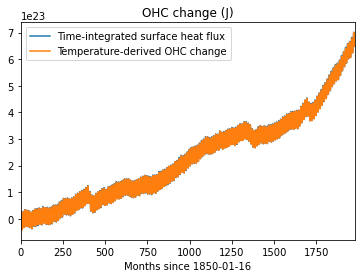

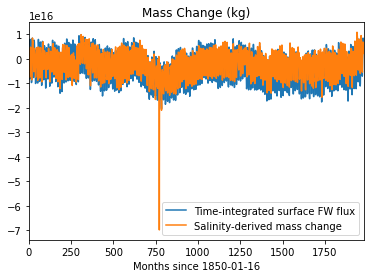

In [159]:
## Check for heat and salt closure
## HEAT
(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time')-(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface heat flux')
((rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum))-(rho*Cp*((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Temperature-derived OHC change')
plt.title('OHC change (J)')
plt.xlabel('Months since 1850-01-16')
plt.xlim(0,1980)

plt.legend()
# plt.savefig('../Figures/glob_hfds_OHC_closure.png', dpi=300, bbox_inches='tight')
plt.show()
## SALT
(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time')-(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=slice(0,120)).mean('Time'))).sum('Basin').sum('Depth').plot(label='Time-integrated surface FW flux')
((-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum)-(-ACCESS_BSP_data.S_mean/S0*rho*ACCESS_BSP_data.V_sum).isel(Time=slice(0,120)).mean('Time')).sum('Basin').sum('Depth').plot(label='Salinity-derived mass change')
plt.title('Mass Change (kg)')
plt.xlabel('Months since 1850-01-16')
plt.legend()
plt.xlim(0,1980)
# plt.savefig('../Figures/glob_wfo_OSC_closure.png', dpi=300, bbox_inches='tight')
plt.show()

In [160]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
# connectivity_array = np.ones((Basins.size,Basins.size))

connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [161]:
# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint
transport_array = np.zeros((Basins.size,Basins.size))

transport_array[4,:] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
transport_array[6,:] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

d = {Basins[0]: transport_array.T[0,:],\
    Basins[1]: transport_array.T[1,:],\
    Basins[2]: transport_array.T[2,:],\
    Basins[3]: transport_array.T[3,:],\
    Basins[4]: transport_array.T[4,:],\
    Basins[5]: transport_array.T[5,:],\
    Basins[6]: transport_array.T[6,:],\
    Basins[7]: transport_array.T[7,:],\
    Basins[8]: transport_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Pacific,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
N. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Ocean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

In [163]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

# connected = np.ones((Vol_1.size, Vol_1.size)) ## For all connections case

trans_big = np.zeros((V_early.values.flatten().size, V_early.values.flatten().size))
connected = np.zeros((V_early.values.flatten().size, V_early.values.flatten().size))

for i in tqdm(range(V_early.values.flatten().size)):
    for j in range(V_late.values.flatten().size):
        trans_big[i,j] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1 ## For NO DOCKING case
            ## UNCOMMENT BELOW IF YOU WANT DOCKING AGAIN
                # if Basin_names[i] == Basin_names[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
                # elif S_start[i]==S_start[j] and T_start[i]==T_start[j]:
                #     connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

# constraints = connected # Shape: An [N x N] matrix

transport = trans_big  # Shape: An [N x N] matrix

  0%|          | 0/144 [00:00<?, ?it/s]

In [189]:

time_scaling_range = np.array([1])#np.logspace(-2,0,3)# = 1e-3#1/(range_yrs*yr2sec)

dOHC = np.zeros(time_scaling_range.size)
dQ_prior = np.zeros(time_scaling_range.size)
dQ_adj = np.zeros(time_scaling_range.size)
dOSC = np.zeros(time_scaling_range.size)
dQS_prior = np.zeros(time_scaling_range.size)
dQS_adj = np.zeros(time_scaling_range.size)

T_adj_array = np.zeros((time_scaling_range.size, V_early.values.flatten().size))
S_adj_array = np.zeros((time_scaling_range.size, V_early.values.flatten().size))

MSE_T = np.zeros(time_scaling_range.size)
MSE_S = np.zeros(time_scaling_range.size)
MSE_tot = np.zeros(time_scaling_range.size)
opt_val = np.zeros(time_scaling_range.size)

for k in range(time_scaling_range.size):
    print(time_scaling_range[k])
    time_scaling = time_scaling_range[k]
    int_scaling = ((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]+1))*time_scaling

    ## Load Q_prior data here
    if SF:
        ## Calculate the cumulative time integrated surface fluxes 
        HFDS_cumsum = (((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1]))\
            -(((ACCESS_BSP_data.hfds_sum+HF_offset_W)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0])) # units: J
        WFO_cumsum = ((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Late_period[-1])\
            -(((ACCESS_BSP_data.wfo_sum+FW_offset_kg_s)*dt.average_DT).cumsum('Time').isel(Time=Early_period[0]))# units: kg

        ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
        dhfds = HFDS_cumsum*int_scaling
        dwfo = WFO_cumsum*int_scaling

        ## Convert dflux to equivalent T or S change
        dT_prior = (dhfds/(Cp*rho*V_early)).values.flatten() # units: C
        dS_prior = (-dwfo*S0/(rho*V_early)).values.flatten() # units: g/kg

        time = ACCESS_BSP_data.Time.values
    else:
        dT_prior = np.zeros_like(ACCESS_BSP_data.hfds_sum.isel(Time=0).values.flatten())
        dS_prior = np.zeros_like(ACCESS_BSP_data.hfds_sum.isel(Time=0).values.flatten())

    # Flatten the early and late variables to a 1D array
    Vol_1 = V_early.values.flatten()
    Vol_2 = V_late.values.flatten()
    S_1 = SAV_early.values.flatten()/Vol_1-S0 # Remove reference salinity S0
    S_2 = SAV_late.values.flatten()/Vol_2-S0 # Remove reference salinity S0
    T_1 = CTV_early.values.flatten()/Vol_1
    T_2 = CTV_late.values.flatten()/Vol_2
    A_1 = A_early.values.flatten()
    A_2 = A_late.values.flatten()

    # Any NaNs are zeroed out
    S_1[np.isnan(S_1)] = 0
    S_2[np.isnan(S_2)] = 0
    T_1[np.isnan(T_1)] = 0
    T_2[np.isnan(T_2)] = 0

    ##Scale by a small amount
    Vol_2_star = Vol_1 + (Vol_2 - Vol_1)*(time_scaling)
    T_2_star = (CTV_early.values.flatten()+\
            (CTV_late.values.flatten()-CTV_early.values.flatten())*(time_scaling))/Vol_2_star
    S_2_star = (SAV_early.values.flatten()+\
            (SAV_late.values.flatten()-SAV_early.values.flatten())*(time_scaling))/Vol_2_star-S0
    A_2_star = A_1 + (A_2 - A_1)*(time_scaling)

    # Any NaNs are zeroed out
    S_2_star[np.isnan(S_2_star)] = 0
    T_2_star[np.isnan(T_2_star)] = 0

    #... and for the edges of the BSP bins
    ## Here we calculate the mean TS edges averaged over both early and late times
    S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
    S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
    T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
    T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

    if SF: 
        ## Add the Q_prior to S_0; T_0 to get the 'initial' state ##
        S_pre = SAV_early.values.flatten()/Vol_1-S0
        S_1 = SAV_early.values.flatten()/Vol_1-S0+dS_prior
        T_pre = CTV_early.values.flatten()/Vol_1
        T_1 = CTV_early.values.flatten()/Vol_1+dT_prior
        S_1[np.isnan(S_1)] = 0
        T_1[np.isnan(T_1)] = 0
        S_1[~np.isfinite(S_1)] = 0
        T_1[~np.isfinite(T_1)] = 0
        S_pre[np.isnan(S_pre)] = 0
        T_pre[np.isnan(T_pre)] = 0
        S_pre[~np.isfinite(S_pre)] = 0
        T_pre[~np.isfinite(T_pre)] = 0

    volumes = np.stack((Vol_1, Vol_2_star), axis=0)/volnorming # Shape: [2 x N]

    salinities = np.stack((S_1, S_2_star), axis=0)
    temps = np.stack((T_1, T_2_star), axis=0)

    tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

    ## We create a weight matrix
    # For sqrt(1/Area)
    A_2_modified = A_2_star.copy()

    A_2_modified[A_2_modified==0] = 1.3*np.nanmin(A_2_star[A_2_star>0])#10**0.5 # this is the lowest I can make it for tree_depth=4 without it breaking

    area_weight = np.sqrt(areanorming/A_2_modified)

    area_cons = A_2_star/A_2_star-1
    area_cons[np.isnan(area_cons)] = 1

    weights = np.stack((S_scale*area_weight, T_scale*area_weight), axis=0) # Shape: An [M x N] matrix
    hard_area = np.stack((area_cons,area_cons), axis=0)

    ## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
    #                                 trans = [transport,trans_val], Asection = [connected_Asection,threshold], weights=weights, hard_area = hard_area)
    if SF:
        result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)#, hard_area = hard_area)
    else:
        result = MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = connected, weights=weights)

    g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
    Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
    Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
    G = result['G'] ## An [ix] matrix of transports between WMs
    opt_val[k] = result['optimal_val']

    N = int(Vol_1.shape[0])

    ########
    nofaces = np.count_nonzero(connected)


    G = np.zeros((int(nofaces)))
    ix=0
    for i in (range(N)):
        for j in range(N):
            if connected[i,j]>0:
                G[ix] = g_ij[i,j]
                ix=ix+1   


    Tmatrix=np.zeros((N,int(nofaces)))
    Smatrix=np.zeros((N,int(nofaces)))

    ix=0
    for i in (range(N)):
        for j in range(N):
            if connected[i,j]>0:
                Tmatrix[j,ix] = tracers[0,1,i] #vertex ix brings temp of WM i to WM j
                Smatrix[j,ix] = tracers[0,0,i] #vertex ix brings temp of WM i to WM j

                ix=ix+1

    dTV = (volumes[1,:]*T_2_star)-(volumes[0,:]*T_pre)
    dTVprior = dT_prior*volumes[0,:]
    T1V1 = volumes[1,:]*T_2_star

    dSV = (volumes[1,:]*S_2_star)-(volumes[0,:]*S_pre)
    dSVprior = dS_prior*volumes[0,:]
    S1V1 = volumes[1,:]*S_2_star

    test = ((Tmatrix@G/volumes[1,:]))
    testS = ((Smatrix@G/volumes[1,:]))
    test[~np.isfinite(test)]= np.nan
    test[test>100] = np.nan
    testS[~np.isfinite(testS)]= np.nan
    testS[testS>100] = np.nan

    test2  = T_2_star - test
    test2[np.isnan(test2)] = 0
    test2S  = S_2_star - testS
    test2S[np.isnan(test2S)] = 0

    T_adj_array[k,:] = test2
    S_adj_array[k,:] = test2S
  
    dQ_adj[k] = np.nansum((T1V1-Tmatrix@G))
    dOHC[k] = np.nansum(dTV)
    dQ_prior[k] = np.nansum(dTVprior)

    dQS_adj[k] = np.nansum(S1V1-Smatrix@G)
    dOSC[k] = np.nansum(dSV)
    dQS_prior[k] = np.nansum(dSVprior)

    A_T = np.zeros_like(Tmatrix)
    A_S = np.zeros_like(Tmatrix)

    for i in range(int(nofaces)):
        A_T[:,i] = Tmatrix[:,i]*weights[1,:]
        A_S[:,i] = Smatrix[:,i]*weights[0,:]

    A = np.concatenate((A_T,A_S),axis=0)
    
    b = np.concatenate((volumes[1,:]*tracers[1,1,:]*weights[1,:],\
                    volumes[1,:]*tracers[1,0,:]*weights[0,:]), axis=0)
    b[np.isnan(b)]=0

    MSE_T[k] = np.nansum(abs(-T1V1*weights[1,:]+(A_T)@G)**2)
    MSE_S[k] = np.nansum(abs(-S1V1*weights[0,:]+(A_S)@G)**2)
    MSE_tot[k] = np.nansum(abs(A@G-b)**2)

1
                                     CVXPY                                     
                                    v1.1.13                                    
(CVXPY) May 01 04:47:22 PM: Your problem has 6912 variables, 2 constraints, and 0 parameters.
(CVXPY) May 01 04:47:22 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 01 04:47:22 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 01 04:47:22 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 01 04:47:22 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 01 04:47:22 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

In [190]:
ACCESS_mapped_masks = xr.open_mfdataset('../Masks_processed/ACCESS_mask_%i_bins_7*.nc' %(tree_depth))

if tree_depth<=4:
    fuzz_combined = (ACCESS_mapped_masks.salt.isel(time=slice(108,216)).sum('time')/(dyrs*12)).values
else:
    fuzz_combined = (ACCESS_mapped_masks.salt.sum('time')/(dyrs*12)).values

mask_ACCESS_xr = xr.open_mfdataset('../Basin_mask/mask_ACCESS.nc')

mask_ACCESS = (mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0).values)

data_ACCESS_hfds = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/hfds_ACCESS_hist_proper.nc') ## hfds: Wm^-2; wfo: kgm^-2s^-1

ACCESS_dArea = xr.open_mfdataset('~/UNSW_Work/ACCESS_CM2/darea_ACCESS_hist_proper.nc').sel(time=slice('1979-01-01',None)).mean('time')
ACCESS_dArea_masked = data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)/data_ACCESS_hfds.__xarray_dataarray_variable__.isel(time=0)*ACCESS_dArea.area_t

In [191]:
dhfds_adj_remapped_Wm2 = np.zeros((time_scaling_range.size, ACCESS_dArea_masked.yt_ocean.size,ACCESS_dArea_masked.xt_ocean.size ))
dhfds_adj_remapped_J = np.zeros((time_scaling_range.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))
dwfo_adj_remapped_mm_day = np.zeros((time_scaling_range.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))
dwfo_adj_remapped_m3 = np.zeros((time_scaling_range.size,ACCESS_dArea_masked.yt_ocean.size, ACCESS_dArea_masked.xt_ocean.size))

for k in tqdm(range(time_scaling_range.size)):
        # Flatten the early and late variables to a 1D array
    Vol_1 = V_early.values.flatten()
    Vol_2 = V_late.values.flatten()
    S_1 = SAV_early.values.flatten()/Vol_1-S0 # Remove reference salinity S0
    S_2 = SAV_late.values.flatten()/Vol_2-S0 # Remove reference salinity S0
    T_1 = CTV_early.values.flatten()/Vol_1
    T_2 = CTV_late.values.flatten()/Vol_2
    A_1 = A_early.values.flatten()
    A_2 = A_late.values.flatten()

    # Any NaNs are zeroed out
    S_1[np.isnan(S_1)] = 0
    S_2[np.isnan(S_2)] = 0
    T_1[np.isnan(T_1)] = 0
    T_2[np.isnan(T_2)] = 0

    ##Scale by a small amount
    Vol_2_star = Vol_1 + (Vol_2 - Vol_1)*(time_scaling_range[k])
    T_2_star = (CTV_early.values.flatten()+\
            (CTV_late.values.flatten()-CTV_early.values.flatten())*(time_scaling_range[k]))/Vol_2_star
    S_2_star = (SAV_early.values.flatten()+\
            (SAV_late.values.flatten()-SAV_early.values.flatten())*(time_scaling_range[k]))/Vol_2_star-S0
    A_2_star = A_1 + (A_2 - A_1)*(time_scaling_range[k])

    # Any NaNs are zeroed out
    S_2_star[np.isnan(S_2_star)] = 0
    T_2_star[np.isnan(T_2_star)] = 0


    ## Calculate the adjustment term
    dS_adj_stacked = S_adj_array[k,:]*(1/time_scaling_range[k])
    dT_adj_stacked = T_adj_array[k,:]*(1/time_scaling_range[k])

    Vol_2_star_da = xr.DataArray(data = Vol_2_star, dims ={'WM_number'}, coords = {'WM_number':np.arange(0,144)})
    A_2_star_da = xr.DataArray(data = A_2_star, dims ={'WM_number'}, coords = {'WM_number':np.arange(0,144)})

    ds_vol_late_stacked = Vol_2_star_da
    ds_area_late_stacked = A_2_star_da
    ds_area_early_stacked = A_early.stack(WM_number = ['Basin', 'Depth'])
    ds_area_early_stacked['WM_number'] = np.arange(0,144)

    mask_WM_basin = mask_ACCESS_xr.mask_ACCESS.isel(st_ocean=0)*(ACCESS_mapped_masks.salt.isel(time=slice(Early_period[0]-1440,Early_period[-1]-1440)).sum('time')/(dyrs*12))
    mask_WM_basin_stacked = mask_WM_basin.stack(WM_number = ['Basins', 'tree_depth'])
    mask_WM_basin_stacked['WM_number'] = np.arange(0,144)

    ### Adjustment in W/m2 for maps
    dhfds_adj_Wm2 = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/(range_yrs*yr2sec*ds_area_late_stacked)
    dhfds_adj_remapped_Wm2_bias = (dhfds_adj_Wm2.where(abs(dhfds_adj_Wm2)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

    ## Adjustment in J for the heat budget
    dhfds_adj_J = dT_adj_stacked*ds_vol_late_stacked*rho*Cp/ds_area_late_stacked

    dhfds_adj_remapped_J_bias = (dhfds_adj_J.where(abs(dhfds_adj_J)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

    dhfds_adj_J_missing = ((dT_adj_stacked*ds_vol_late_stacked*rho*Cp).sum('WM_number')-\
                                    (dhfds_adj_remapped_J_bias).sum(['xt_ocean','yt_ocean']))

    dhfds_adj_remapped_Wm2_missing = dhfds_adj_J_missing/(range_yrs*yr2sec*np.nansum(ACCESS_dArea_masked.values))
    dhfds_adj_remapped_Wm2[k,:,:] = dhfds_adj_remapped_Wm2_bias+dhfds_adj_remapped_Wm2_missing
    dhfds_adj_remapped_J[k,:,:] = dhfds_adj_remapped_J_bias+dhfds_adj_J_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked

    dwfo_adj_mm_day = -dS_adj_stacked*ds_vol_late_stacked/(range_yrs*yr2sec*ds_area_late_stacked*S0)*24*3600*1000
    dwfo_adj_remapped_mm_day_bias = (dwfo_adj_mm_day.where(abs(dwfo_adj_mm_day)!=np.inf, 0)*mask_WM_basin_stacked).sum('WM_number')

    ## Adjustment in m3 for the FW budget
    dwfo_adj_m3 = -dS_adj_stacked*ds_vol_late_stacked/(S0*ds_area_late_stacked)
    dwfo_adj_remapped_m3_bias = (dwfo_adj_m3.where(abs(dwfo_adj_m3)!=np.inf, 0).fillna(0)*mask_WM_basin_stacked).sum('WM_number')*ACCESS_dArea_masked

    dwfo_adj_m3_missing = ((-dS_adj_stacked*ds_vol_late_stacked/S0).sum('WM_number')-\
                                    (dwfo_adj_remapped_m3_bias).sum(['xt_ocean','yt_ocean']))

    dwfo_adj_remapped_mm_day_missing = dwfo_adj_m3_missing/(range_yrs*yr2sec*np.nansum(ACCESS_dArea_masked.values))*24*3600*1000
    dwfo_adj_remapped_mm_day[k,:,:] = dwfo_adj_remapped_mm_day_bias+dwfo_adj_remapped_mm_day_missing
    dwfo_adj_remapped_m3[k,:,:] = dwfo_adj_remapped_m3_bias+dwfo_adj_m3_missing/(np.nansum(ACCESS_dArea_masked.values))*ACCESS_dArea_masked

  0%|          | 0/1 [00:00<?, ?it/s]

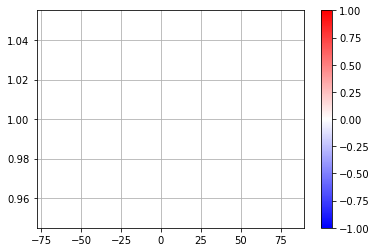

In [193]:

plt.pcolor(ACCESS_dArea_masked.yt_ocean, time_scaling_range, np.cumsum(np.nansum(dhfds_adj_remapped_J,axis=-1),axis=-1)/(range_yrs*yr2sec*1e15), vmin=-1, vmax=1, cmap=plt.cm.bwr)
# plt.yscale('log')
plt.colorbar()
plt.grid()

1


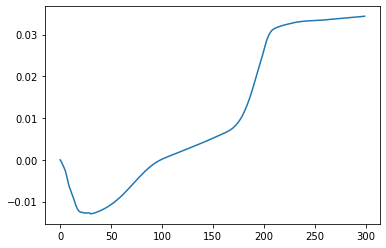

In [194]:
print(time_scaling_range[-1])
plt.plot((np.cumsum(np.nansum(dhfds_adj_remapped_J[-1,:,:],axis=-1),axis=-1)/(range_yrs*yr2sec*1e15)))


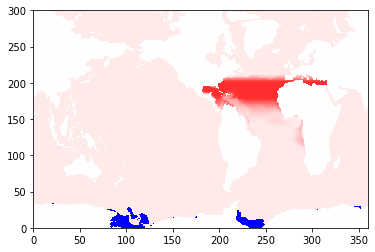

In [201]:
plt.pcolor(dhfds_adj_remapped_Wm2[-1,:,:], vmin=-1, vmax=1, cmap=plt.cm.bwr)

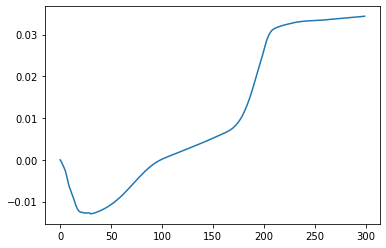

In [196]:
plt.plot((np.cumsum(np.nansum(dhfds_adj_remapped_J[-1,:,:],axis=-1),axis=-1)/(range_yrs*yr2sec*1e15)))


In [198]:
print(dOHC[0]*volnorming*rho*Cp)
print(dQ_prior[0]*volnorming*rho*Cp)
print(dQ_adj[0]*volnorming*rho*Cp)

8.674078400836024e+22
7.697445622444622e+22
9.766437433361335e+21


In [202]:
print(np.nancumsum(dOHC[0]*volnorming)*rho*Cp)

[8.6740784e+22]


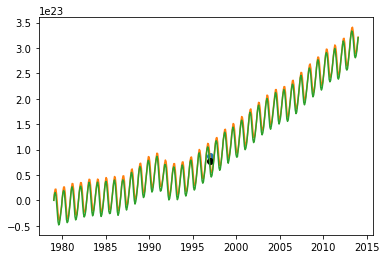

In [200]:
plt.plot(1997, np.nancumsum(dOHC[0]*volnorming)*rho*Cp, 'o')
plt.plot(np.linspace(1979,2014,432), \
         rho*Cp*(((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=slice(1548, None)).sum(['Basin', 'Depth']).values-\
            ((ACCESS_BSP_data.T_mean-273.15)*ACCESS_BSP_data.V_sum).isel(Time=1548).sum(['Basin', 'Depth']).values))

plt.plot(1997, np.nancumsum(dQ_prior[0]*volnorming)*rho*Cp, 'ko')
plt.plot(np.linspace(1979,2014,432), \
         ((ACCESS_BSP_data.hfds_sum*dt.average_DT).isel(Time=slice(1548, None)).sum(['Basin', 'Depth']).cumsum('Time').values-\
            (ACCESS_BSP_data.hfds_sum*dt.average_DT).isel(Time=1548).sum(['Basin', 'Depth']).values))


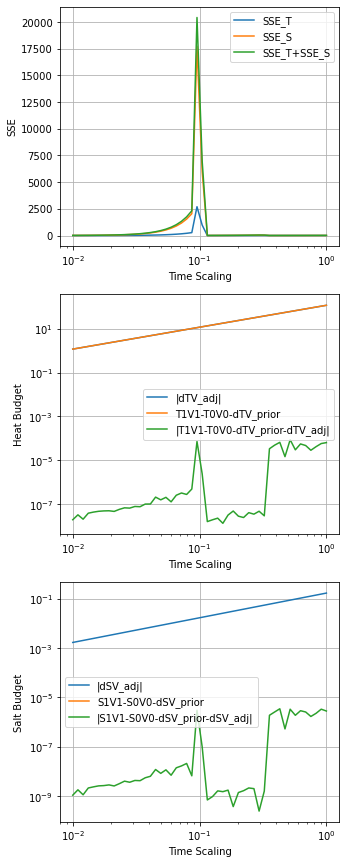

In [54]:
fig, axs = plt.subplots(3,1, figsize=(5,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()

axs[0].semilogx(time_scaling_range, MSE_T, label = 'SSE_T')
axs[0].semilogx(time_scaling_range, MSE_S, label = 'SSE_S')
axs[0].semilogx(time_scaling_range, MSE_tot, label = 'SSE_T+SSE_S')
axs[0].grid()
axs[0].legend()

axs[0].set_ylabel('SSE')
axs[0].set_xlabel('Time Scaling')

axs[1].semilogx(time_scaling_range, abs(dQ_adj), label ='|dTV_adj|')
axs[1].semilogx(time_scaling_range, -dQ_prior+dOHC, label = 'T1V1-T0V0-dTV_prior')
axs[1].semilogx(time_scaling_range, abs(dQ_adj+dQ_prior-dOHC), label = '|T1V1-T0V0-dTV_prior-dTV_adj|')
axs[1].set_ylabel('Heat Budget')
axs[1].set_xlabel('Time Scaling')

axs[1].set_yscale('log')
axs[1].legend()
axs[1].grid()

axs[2].semilogx(time_scaling_range, abs(dQS_adj), label ='|dSV_adj|')
axs[2].semilogx(time_scaling_range, -dQS_prior+dOSC, label = 'S1V1-S0V0-dSV_prior')
axs[2].semilogx(time_scaling_range, abs(dQS_adj+dQS_prior-dOSC), label = '|S1V1-S0V0-dSV_prior-dSV_adj|')
axs[2].set_ylabel('Salt Budget')
axs[2].set_xlabel('Time Scaling')

axs[2].set_yscale('log')
axs[2].legend()
axs[2].grid()

plt.savefig('../Figures/Actual_Qprior_budgets_timescaling_oppobias.png', dpi=300, bbox_inches='tight')
plt.show()

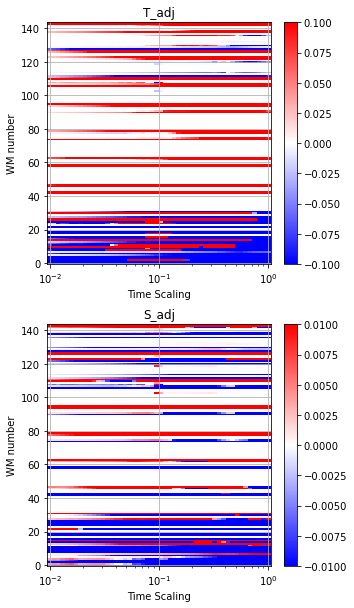

In [55]:
fig, axs = plt.subplots(2,1, figsize=(5,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=0.2)
axs = axs.ravel()
im0 = axs[0].pcolor(time_scaling_range, np.arange(144), T_adj_array.T, vmin=-1e-1, vmax=1e-1, cmap=plt.cm.bwr)
axs[0].set_xscale('log')
axs[0].grid()
axs[0].set_ylabel('WM number')
axs[0].set_xlabel('Time Scaling')
axs[0].set_title('T_adj')
fig.colorbar(im0, ax=axs[0])  # Add colorbar to the first subplot

im1 = axs[1].pcolor(time_scaling_range, np.arange(144), S_adj_array.T, vmin=-1e-2, vmax=1e-2, cmap=plt.cm.bwr)
axs[1].set_xscale('log')
axs[1].grid()
axs[1].set_ylabel('WM number')
axs[1].set_xlabel('Time Scaling')
axs[1].set_title('S_adj')
fig.colorbar(im1, ax=axs[1])  # Add colorbar to the first subplot
plt.savefig('../Figures/Actual_Qprior_TS_adj_timescaling_oppobias.png', dpi=300, bbox_inches='tight')
plt.show()

---------------
## C) Define Constraints

### i) Define Connectivity

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.


### ii) Define Weights

-----------------
## D) Run Optimisation

In [ ]:
S_2_star

array([-2.44527385, -0.48553451, -3.93674971, -0.52199347, -0.4002662 ,
       -0.14312377, -0.33615517,  0.10771156, -4.11507252, -0.53745475,
       -4.71441733, -0.53089683,  0.08718099,  0.52565025,  0.24185258,
        2.29710172, -3.42832899,  0.        , -2.83073152, -0.53961764,
        0.        , -0.13134139, -0.39792512,  0.09149524, -2.04830447,
       -0.53586454, -1.30083665, -0.52314877,  0.12276025,  0.54842101,
        0.34045522,  2.70690276,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.13322707,  0.        ,  0.08248497,
        0.        ,  0.        , -1.26105224, -0.52530937,  0.11370336,
        0.32039969,  0.3270321 ,  0.78794367,  0.        ,  0.        ,
        0.        ,  0.        , -0.36898793, -0.15069877, -0.27931635,
        0.01176422,  0.        , -0.41228568, -0.91679835, -0.51444704,
       -0.09883228,  0.24145386,  0.09602356,  1.1163979 , -0.53551381,
       -0.48180406, -0.6224511 , -0.49038916, -0.36334511, -0.26

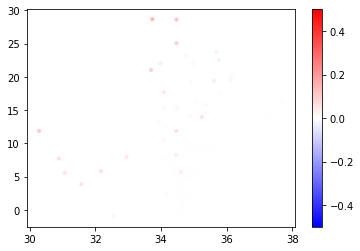

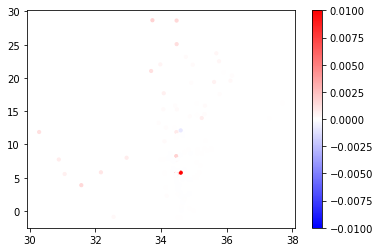

In [ ]:
plt.scatter(S_2_star+S0, T_2_star, 10, c=test2, vmin=-0.5, vmax=0.5, cmap=plt.cm.bwr)
plt.colorbar()
plt.show()
plt.scatter(S_2_star+S0, T_2_star, 10, c=test2S, vmin=-0.01, vmax=0.01, cmap=plt.cm.bwr)
plt.colorbar()
plt.show()

dTV_adj =  1548731278288771.8\
T1V1-T0V0 =  5.970754610608535e+16\
dTpriorV0 =  5.815887594014721e+16\
-(T1V1-T0V0)+dTV_adj+dTpriorV0 [x10^10]=  6.111235062775\
dSV_adj =  4.520316659759652e+19\
S1V1-S0V0 =  4.520307182865577e+19\
dSpriorV0 =  -94772334971750.64\
-(S1V1-S0V0)+dSV_adj+dSpriorV0 [x10^10]=  -0.3394215936

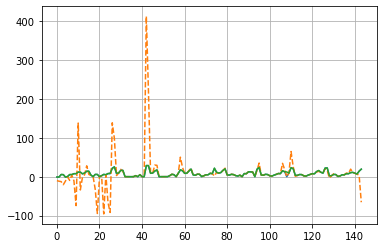

In [ ]:
plt.plot(T_pre)
plt.plot(T_1, linestyle='dashed') # T_1 = T_pre+dT_prior
plt.plot(T_2)
plt.grid()

In [ ]:
print(np.argmax(T_2-T_1))

22


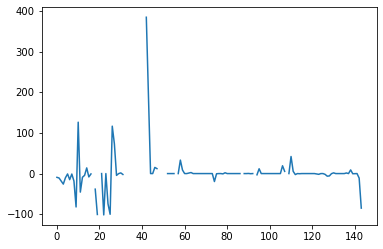

In [ ]:
plt.plot(dT_prior)

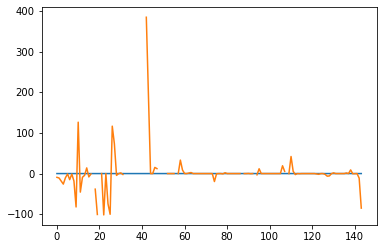

In [ ]:
Tmixed = Tmatrix@G/volumes[1,:]
Tmixed[~np.isfinite(Tmixed)]= np.nan
Tmixed[Tmixed>100] = np.nan
Smixed = Smatrix@G/Vol_2
Smixed[~np.isfinite(Smixed)]= np.nan
Smixed[Smixed>10**4] = np.nan

# Now the necessary heat and salt adjustment is simply the difference
# between this and what we actually get
T_Av_adj = (T_2_star-Tmixed)
T_Av_adj[np.isnan(T_Av_adj)] = 0
# plt.plot(CTV_late.values.flatten()/Vol_2)
plt.plot(T_Av_adj)
plt.plot(dT_prior)
# plt.plot((T_2-T_pre))

dTV_adj =  0.15487312417817745
dTV_adj =  0.0003973170548931975
dTV_adj =  0.0003973170548931975


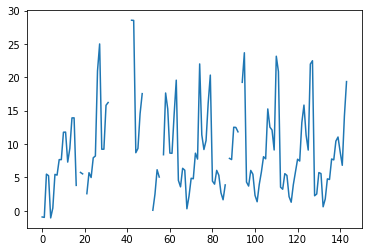

In [ ]:
plt.plot(Tmixed)
print('dTV_adj = ',np.nansum((T1V1*volnorming-Tmatrix@G*volnorming)*1/time_scaling)/1e16)
print('dTV_adj = ',np.nansum(T_Av_adj*A_2_star*1/time_scaling)/1e16)
print('dTV_adj = ',np.nansum(T_Av_adj*A_2*1/time_scaling)/1e16)


In [ ]:
print(np.nansum(Vol_2))
print(np.nansum(Vol_2_star))


1.2915184735811986e+18
1.2915184735811986e+18


In [ ]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]
dS_adj = Adjustment[0,:]
dT_adj = Adjustment[1,:]

----------
## E) Save Output 

In [ ]:
file_path = '../Optimisation_results/ACCESS_CM2_scaled_1e6_transports.nc'

In [ ]:
import os
if os.path.exists(file_path):
   os.remove(file_path)
   print('File deleted')

da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="EN4 Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="EN4 Smix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="EN4 Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="EN4 Sadj"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="EN4 Gij"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['gij'] = da_gij

ds_BSP.to_netcdf(file_path, mode='w')
print('File saved')


File deleted
File saved
